In [ ]:
# Fill in your names using the format below and student ID number
group_id = "YOUR_ID"
team_member_1 = "LAST_NAME, FIRST_NAME, STUDENT_ID"
team_member_2 = "LAST_NAME, FIRST_NAME, STUDENT_ID"
team_member_3 = "LAST_NAME, FIRST_NAME, STUDENT_ID"
team_member_4 = "LAST_NAME, FIRST_NAME, STUDENT_ID"
team_member_5 = "LAST_NAME, FIRST_NAME, STUDENT_ID"
team_member_6 = "LAST_NAME, FIRST_NAME, STUDENT_ID"

In [ ]:
# For Google Colab
!pip install openml --quiet
!pip install category_encoders --quiet
!pip install -U scikit-learn --quiet
!pip install dirty_cat --quiet

     |████████████████████████████████| 119 kB 5.3 MB/s 
     |████████████████████████████████| 75 kB 3.6 MB/s 
     |████████████████████████████████| 82 kB 363 kB/s 
     |████████████████████████████████| 23.1 MB 1.6 MB/s 
     |████████████████████████████████| 155 kB 5.2 MB/s 


# Assignment 2
The [Employee Salary dataset](https://www.openml.org/d/42125) contains information about the salaries of all people working in a local government
in the USA. It is a good example of a somewhat 'messy' real-world dataset that contains many different kinds of categories. This requires thoughtful preprocessing rather than just a grid search over all possible models. In the end we will aim to predict the salaries of people, and study whether there are
certain biases in the data that we need to be aware of and how to avoid them when training models. 

In [ ]:
# imports
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import openml
import time
start_time = time.time()

# ignore future warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

### Additional packages:
* TargetEncoder
    - Run `pip install category_encoders` or `conda install -c conda-forge category_encoders`
* Seaborn (plotting)
    - Run `pip install seaborn` or `conda install seaborn`

In [ ]:
# Pre-flight checklist. Do not change this code.
# Make sure that you have installed recent versions of key packages.
# You could lose points if these checks do not pass.
from packaging import version
import sklearn
import category_encoders
import seaborn

sklearn_version = sklearn.__version__
catencoder_version = category_encoders.__version__
if version.parse(sklearn_version) < version.parse("0.24.0"):
    print("scikit-learn is outdated. Please update now!")
elif version.parse(catencoder_version) < version.parse("2.0.0"):
    print("category_encoders is outdated. Please update now!")
else:
    print("OK. You may continue :)")

OK. You may continue :)


In [ ]:
# Download Employee Salary data. Do not change this code!
# Note that X is a pandas dataframe 
salary = openml.datasets.get_dataset(42125)
X, y, _, feat_names = salary.get_data(target=salary.default_target_attribute)

In [ ]:
# Peek at the remaining data
X

,full_name,gender,2016_gross_pay_received,2016_overtime_pay,department,department_name,division,assignment_category,employee_position_title,underfilled_job_title,date_first_hired,year_first_hired
0,"Aarhus, Pam J.",F,71225.98,416.10,POL,Department of Police,MSB Information Mgmt and Tech Division Records...,Fulltime-Regular,Office Services Coordinator,None,09/22/1986,1986
1,"Aaron, David J.",M,103088.48,3326.19,POL,Department of Police,ISB Major Crimes Division Fugitive Section,Fulltime-Regular,Master Police Officer,None,09/12/1988,1988
2,"Aaron, Marsha M.",F,107000.24,1353.32,HHS,Department of Health and Human Services,Adult Protective and Case Management Services,Fulltime-Regular,Social Worker IV,None,11/19/1989,1989
3,"Ababio, Godfred A.",M,57819.04,3423.07,COR,Correction and Rehabilitation,PRRS Facility and Security,Fulltime-Regular,Resident Supervisor II,None,05/05/2014,2014
4,"Ababu, Essayas",M,95815.17,NaN,HCA,Department of Housing and Community Affairs,Affordable Housing Programs,Fulltime-Regular,Planning Specialist III,None,03/05/2007,2007
...,...,...,...,...,...,...,...,...,...,...,...,...
9223,"Zurita, Justina",F,58154.47,NaN,HHS,Department of Health and Human Services,School Based Health Centers,Fulltime-Regular,Community Health Nurse II,None,11/03/2015,2015
9224,"Zuspan, Diane M.",F,173173.01,956.97,FRS,Fire and Rescue Services,Human Resources Division,Fulltime-Regular,Fire/Rescue Division Chief,None,11/28/1988,1988
9225,"Zwerdling, David",M,104238.18,NaN,HHS,Department of Health and Human Services,Child and Adolescent Mental Health Clinic Serv...,Parttime-Regular,Medical Doctor IV - Psychiatrist,None,04/30/2001,2001
9226,"Zyontz, Jeffrey L.",M,149105.25,NaN,CCL,County Council,Council Central Staff,Fulltime-Regular,Manager II,None,09/05/2006,2006


In [ ]:
# Check the column data types and missing data
# Some features have significant amounts of missing values
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9228 entries, 0 to 9227
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   full_name                9228 non-null   object  
 1   gender                   9211 non-null   category
 2   2016_gross_pay_received  9128 non-null   float64 
 3   2016_overtime_pay        6311 non-null   float64 
 4   department               9228 non-null   category
 5   department_name          9228 non-null   category
 6   division                 9228 non-null   object  
 7   assignment_category      9228 non-null   category
 8   employee_position_title  9228 non-null   object  
 9   underfilled_job_title    1093 non-null   object  
 10  date_first_hired         9228 non-null   object  
 11  year_first_hired         9228 non-null   int64   
dtypes: category(4), float64(2), int64(1), object(5)
memory usage: 616.2+ KB


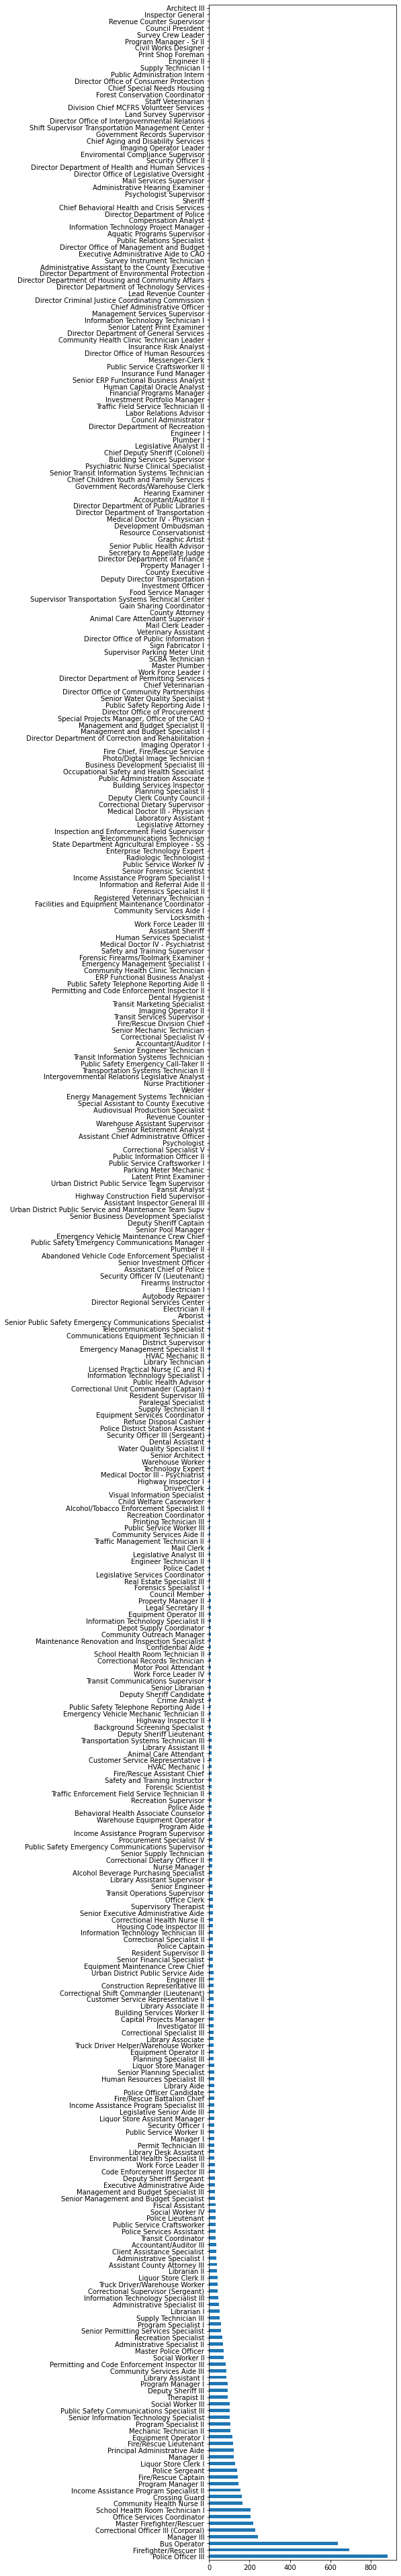

In [ ]:
# Some categorical columns have a large number of possible values
# And some values (job positions) are much more frequent than others
X['employee_position_title'].value_counts().plot(kind='barh', figsize=(5,70));

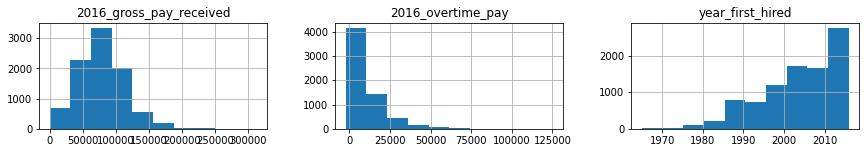

In [ ]:
# Distributions of numeric data
X.hist(layout=(20,4), figsize=(20,50));

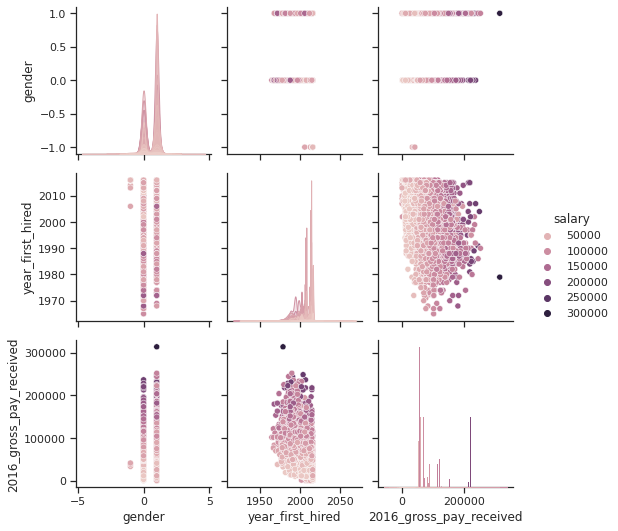

In [ ]:
# How do the numeric features correlate with each other? And with salary?
import seaborn as sns
subset = ['gender','year_first_hired','2016_gross_pay_received']
X_sub=X[subset].copy()
# Gender is not numeric, but we can make it numeric (0/1) for this plot
X_sub['gender'] = X_sub['gender'].astype('category').cat.codes
X_sub['salary'] = y 
sns.set(style="ticks")
sns.pairplot(X_sub, hue="salary");

## Part 1: Preprocessing

### Question 1.1 (5 points)
To be able to do anything with most scikit-learn algorithms, we need to encode the categorical features. Because we want to avoid any data leakage, we will design a pipeline fpr this. Implement a function `simple_pipeline` that returns an sklearn pipeline that preprocesses the data in a minimal way before running a given algorithm:
- Categorical features:
    - Impute missing values by replacing them with the most frequent value for that feature
    - Perform one-hot encoding. Use `sparse=False` to avoid that it returns a sparse datasets. Use `handle_unknown='ignore'` to ignore categorical values that where not seen during training.
- Numeric features:
    - Replace missing values with '0'. This seems most logical since a missing salary or overtime pay likely means that it was 0.

In [ ]:
# Implement
def simple_pipeline(X, model):
    """ Returns a minimal pipeline that imputes missing values and does one-hot-encoding for categorical features
    Keyword arguments:
    X -- The input data. Only used to identify features types (eg. numeric/categorical), not for training the pipeline.
    model -- any scikit-learn model (e.g. regressor or classifier)
    Returns: an (untrained) scikit-learn pipeline which preprocesses the data and then runs the classifier
    """
    # List of numerical features. You get this for free :)
    numerical = X.select_dtypes(exclude=["category","object"]).columns.tolist()
    pass

In [ ]:
### MODEL SOLUTION
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

def simple_pipeline(X, model):
    numerical = X.select_dtypes(exclude=["category","object"]).columns.tolist()
    cat_pipe = make_pipeline(SimpleImputer(strategy='most_frequent'),OneHotEncoder(sparse=False, handle_unknown='ignore'))
    num_pipe = make_pipeline(SimpleImputer(strategy='constant',fill_value=0))
    transform = make_column_transformer((num_pipe, numerical), remainder=cat_pipe)
    return make_pipeline(transform, model)

#### Sanity check
To be correct, this pipeline should be able to fit any model without error. Run this code to do a sanity check.

In [ ]:
from sklearn.tree import DecisionTreeRegressor
simple_pipeline(X, DecisionTreeRegressor()).fit(X,y);

### Question 1.2 (2 points)
We now do a little experiment to clean up the features
* Implement a function 'evaluate_tree' that evaluates a decision tree regressor on the dataset using 3-fold shuffled crossvalidation and r2 score (coefficient of determination), using the pipeline creation method you just implemented. Use `random_state=0` for the shuffling and the decision tree regressor. Run it on the full dataset and report the average train and test scores
* Next, remove the features 'full_name','department', and 'date_first_hired'. You can use the helper code below.
* Repeat the same experiment. Report the average train and test scores.
* Interpret the results. Can you safely remove these features and is it wise to do so? Why (or why not)? Consider this question for the three features individually. Also consider what happens with these features in your preprocessing pipeline. Also consider any potential ethical issues. Fill in your answer in `q_1_2`. 


In [ ]:
# Implement
def evaluate_tree(X):
    """ Evaluates a decision tree regressor using 3-fold cross-validation, 
    and returns the training and test r2 score. Further details in the question above.
    Keyword arguments:
    X -- The input data. 
    """
    pass

In [ ]:
# Fill in the correct answer. Don't change the name of the variable
q_1_2 = """
        Your answer here.
        """

In [ ]:
### MODEL SOLUTION
from sklearn.model_selection import cross_validate, KFold
from sklearn.tree import DecisionTreeRegressor
def evaluate_tree(X):
  cvs = KFold(n_splits=3, shuffle=True, random_state=0)
  cv_scores = cross_validate(simple_pipeline(X, DecisionTreeRegressor(random_state=0)), X, y, return_train_score=True, cv=cvs, n_jobs=3, scoring='r2')
  return np.mean(cv_scores['train_score']), np.mean(cv_scores['test_score'])

print("With all features: Train score (r2) = {}, Test score (r2) = {}".format(*evaluate_tree(X)))
cols = [c for c in X.columns if c.lower() not in ['full_name','department','date_first_hired']]
print("With selected features: Train score (r2) = {}, Test score (r2) = {}".format(*evaluate_tree(X[cols])))

With all features: Train score (r2) = 1.0, Test score (r2) = 0.9565659316294949
With selected features: Train score (r2) = 0.9999994885643521, Test score (r2) = 0.9591842939298333


In [ ]:
### MODEL SOLUTION
q_1_2 = """
        Yes, these can be safely removed. The train and test score are about the same, so they do not seem to affect the model, although with close to perfect r2 training score, both models seem to be overfitting.
        The first feature 'full_name' is unique for every row and should be removed anyway. Not only does it not carry information, the one-hot encoder will create a lot of meaningless features. Finally, there is an ethical issue
        it letting the model store the names of people in the model. 'department' is a duplicate feature since it is just a shorthand for the 'department_name'. The 'date_first_hired' might in principle be useful, but it is largely
        redundant since we already have the 'year_first_hired', and salaries don't change so rapidly. Also, it is encoded as a category, which destroys any time information. To include it properly, it should be converted to a numeric
        timestamp. You can get slightly different results with different random seeds, but the effect is very small.
        """

### Question 1.3 (2 points)
From here, and for the rest of the assignment, remove the three columns discussed in question 1.2 as done below (we overwrite 'X' for convenience). We also remove '2016_gross_pay_received' and '2016_overtime_pay' as they are very closely linked to the target column ('current salary'), hence making this task a little too easy.

Next question: How many features are still being constructed by your `simple_pipeline` (i.e. on how many features is the classifier trained)? Also explain why this amount of features are constructed.

In [ ]:
cols = [c for c in X.columns if c.lower() not in ['full_name','department','date_first_hired','2016_gross_pay_received', '2016_overtime_pay']]
X = X[cols]

In [ ]:
# Fill in the correct answer (should be an integer), and provide an explanation. Don't change the name of the variable
q_1_3 = """
        Your answer here.
        """

In [ ]:
### MODEL SOLUTION
pipe = simple_pipeline(X, DecisionTreeRegressor()).fit(X,y) # The choice of model doesn't matter
print("There are {} features".format(np.shape(pipe.named_steps['columntransformer'].transform(X))[1]))

# Extra: breakdown per type
# One-hot-encoding constructs a new feature per possible category 
categorical = X.select_dtypes(include=["category","object"]).columns.tolist()
for f in categorical:
    print("{}: {}".format(f,len(X[f].value_counts())))

There are 1206 features
gender: 2
department_name: 37
division: 694
assignment_category: 2
employee_position_title: 385
underfilled_job_title: 84


### Question 1.4 (3 points)
Implement a function `flexible_pipeline` that has two additional options:
- Allow to choose a feature scaling method for numeric features. The default is standard scaling. 'None' means no scaling
- Allow to choose a feature encoding method for categorical features. The default is one-hot encoding.

In [ ]:
# Implement
from sklearn.preprocessing import StandardScaler
def flexible_pipeline(X, model, scaler=StandardScaler(), encoder=OneHotEncoder()):
    """ Returns a pipeline that imputes all missing values, encodes categorical features and scales numeric ones
    Keyword arguments:
    X -- The input data. Only used to identify features types (eg. numeric/categorical), not for training the pipeline.
    model -- any scikit-learn model (e.g. a classifier or regressor)
    scaler -- any scikit-learn feature scaling method (Optional)
    encoder -- any scikit-learn category encoding method (Optional)
    Returns: a scikit-learn pipeline which preprocesses the data and then runs the trained model
    """
    pass

In [ ]:
### MODEL SOLUTION
def flexible_pipeline(X, model, scaler=StandardScaler(), encoder=OneHotEncoder()):
    numerical = X.select_dtypes(exclude=["category","object"]).columns.tolist()
    cat_pipe = make_pipeline(SimpleImputer(strategy='most_frequent'),encoder)
    num_pipe = make_pipeline(SimpleImputer(strategy='constant',fill_value=0),scaler)
    transform = make_column_transformer((num_pipe, numerical), remainder=cat_pipe)
    return make_pipeline(transform, model)

#### Sanity check
To be correct, this pipeline should be able to fit any model and encoder without error. Run this code to do a sanity check.

In [ ]:
flexible_pipeline(X, DecisionTreeRegressor(random_state=0), encoder=OneHotEncoder()).fit(X,y);

### Question 1.5 (2 points)
Use your `flexible_pipeline` to finetune the hyperparameters of a Support Vector Regressor
in combination with an OrdinalEncoder.
- You can use a grid search or random search. Optimize the r2 score.
- Tune the C and gamma hyperparameters, at least from 1e-4 to 1e3.
- Report the optimal C and gamma values.

In [ ]:
# MODEL SOLUTION
from sklearn.utils.fixes import loguniform
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import OrdinalEncoder
from sklearn.svm import SVR

distributions = {'svr__C': loguniform(1e-4, 1e3), 'svr__gamma': loguniform(1e-4, 1e3), 'svr__kernel': ['rbf']}
pipe = flexible_pipeline(X,SVR(),encoder=OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
search = RandomizedSearchCV(pipe, distributions, random_state=0, n_jobs=-1, scoring='r2').fit(X, y)
print(search.best_params_)

{'svr__C': 556.7232047731104, 'svr__gamma': 0.04831596208381852, 'svr__kernel': 'rbf'}


## Part 2: Encoders

### Question 2.1 (6 points)
Implement a function `plot_2_1` which plots a heatmap comparing several combinations of catergory encoders and models:
* As model, the following algorithms in their default hyperparameters settings: 
    * Ridge regression
    * Lasso regression
    * SVM with RBF kernel, and the optimized hyperparameters from question 1.4
    * Random Forest
* As encoders, use the following options in their default settings:
    * One-Hot encoder (with `sparse=False`)
    * Ordinal encoder
    * Target encoder

Always use standard scaling. You should evaluate all pipelines using r2 score (coefficient of determination) with 5-fold cross-validation. 
Compare all methods with the same cross-validation folds, shuffle the data and use `random_state=0`. Where possible, also use `random_state=0` for the models. 
Only report the test scores (not the training scores).

Note 1: When encoding categorical values, it is possible to see a category at test time that you did not see at training time, in which case you don't have an encoding for that category, resulting (by default) in an error. For one-hot encoded categories, you can work around this by ignoring the category (all one-hot encoded features will then be zero). For ordinal encoding, you can assing a new value (e.g. '-1') for all unknown categories. For target encoding, the default is to return the target mean. These strategies can be set when creating the encoding.

Note 2: TargetEncoding is part of the category encoders extension of scikit-learn. [Read more about it.](https://contrib.scikit-learn.org/category_encoders/targetencoder.html)
We found that the implementation may have a bug that returns NaN values. You can work around it by wrapping it in a small pipeline followed by a SimpleImputer that replaces NaNs with the mean of the encoded values.

In [ ]:
### Helper plotting function. Do not change.
import seaborn as sns
def heatmap(columns, rows, scores):
    """ Simple heatmap.
    Keyword arguments:
    columns -- list of options in the columns
    rows -- list of options in the rows
    scores -- numpy array of scores
    """
    plt.figure() 
    df = pd.DataFrame(scores, index=rows, columns=columns)
    sns.heatmap(df, cmap='RdYlGn_r', linewidths=0.5, annot=True, fmt=".3f")

In [ ]:
from category_encoders import TargetEncoder
# Implement
def plot_2_1(X, y):
    """ Evaluates a range of models with different categorical encoders and 
    plots the results in a heat map.
    """
    pass

In [ ]:
### MODEL SOLUTION
from sklearn.preprocessing import OrdinalEncoder
from category_encoders import TargetEncoder
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import cross_validate, KFold
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from tqdm.notebook import tqdm as tqdm

# Helper function to construct the score matrix
def heatmap_helper(X, y, models, options, option='encoder'):
    o_names = [o.__class__.__name__ if o.__class__.__name__ != "Pipeline" else o[0].__class__.__name__ for o in options]
    m_names = [m.__class__.__name__ for m in models]
    scores = []
    fit_times = []
    cvs = KFold(n_splits=5, shuffle=True, random_state=0)
    for o, name in tqdm(zip(options,o_names), leave=False):
        o_scores = []
        o_times = []
        for m in tqdm(models, leave=False):
            if option == 'scaler':
                ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
                pipe = flexible_pipeline(X,m,scaler=o,encoder=ohe)
            elif option == 'encoder':
                pipe = flexible_pipeline(X,m,encoder=o)
            cv_scores = cross_validate(pipe, X, y, cv=cvs, n_jobs=-1, scoring='r2')
            o_scores.append(np.mean(cv_scores['test_score']))
            o_times.append(np.mean(cv_scores['fit_time']))
        scores.append(o_scores)
        fit_times.append(o_times)
    heatmap(m_names, o_names, scores)
    heatmap(m_names, o_names, fit_times)

0it [00:00, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

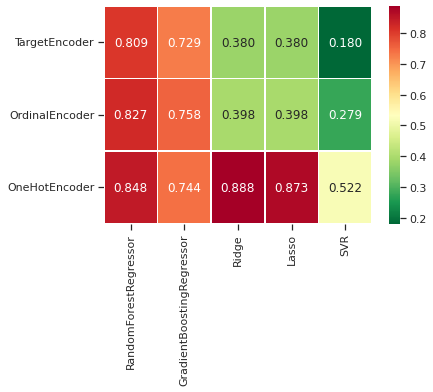

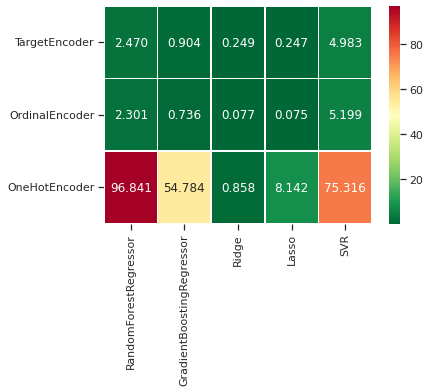

In [ ]:
def plot_2_1(X, y):
    models = [RandomForestRegressor(random_state=0),
              GradientBoostingRegressor(random_state=0),
              Ridge(random_state=0),
              Lasso(random_state=0),
              SVR(C=556, gamma=0.05)]
    options = [make_pipeline(TargetEncoder(return_df=True),SimpleImputer(strategy='mean')), 
               OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), 
               OneHotEncoder(sparse=False, handle_unknown='ignore')]
    heatmap_helper(X, y, models, options, option='encoder')
plot_2_1(X, y)

### Question 2.2 (3 points)
Interpret the results as well as you can:
- Which models work well in combination with certain encoders? Why do you think that is? 
- How do you explain the cases where performance is not good?
- What is the effect on the encodings on training time?

Remember that some encoders produce lots of features while others produce very few. What is the effect of that on different kinds of models?  Try to show insight into how the different encoders and models work. Provide your answer in q_2_2.



In [ ]:
# Fill in your explanation. Don't change the name of the variable
q_2_2 = """
        Your answer here.
        """

In [ ]:
### MODEL SOLUTION
q_2_2 = """
        The one-hot encoder performs surprisingly well, except for SVMs. The best performance is seen with linear models, 
        since they can learn complex functions in the high-dimensional space created by the one-hot-encoded features.
        The linear models do not work well with ordinal encoding, since the 'order' is meaningless but the linear 
        models will assume that the order is important. E.g. in 'employee position', a police officer could get value
        '1' and a bus driver could get value '2' but that does not mean that one is 'more' that the other.    
        This is less of an issue for the decision-tree based models, since they can build sub-trees for each 
        individual value (e.g. for each employee position). The tree-based models also work well with one-hot
        encoders since they are very good at selecting the features which are most important. 
        The target encoder works less well than expected. This is likely because the categorical features are 
        quite skewed. For instance, some employee positions only occur once or twice, which does not provide
        enough information to assign a good value.

        The one-hot encoders create a lot of new features which leads to significantly longer training times, except
        for the linear models, which scale well with the number of features. 

        The SVM models perform poorly - they may require more careful tuning.
        """

### Question 2.3 (4 points)
Now, for something special, we will try the 'SuperVectorizer', a new automated feature encoder that tries to build the best encoding based on how many distinct categories there are. It is also robust against features with many possible values and even typos in category names. In these cases, it encodes features by learning an 'embedding' (a numeric vector representation) based on the similarity of category names. [Read more about it here](https://arxiv.org/abs/1907.01860) but be aware that the paper is quite technical :).

Note: The SuperVectorizer only works on string features, so create a copy of X and convert all non-numeric features to strings.

* Implement a function `plot_2_3` that evaluates the same algorithms as above, and returns a heatmap (just as in question 2.1), but now using the SuperVectorizer.
* Interpret the results in `q_2_3`. Is the performance better? Does it work well together with some specific models? Explain as well as possible. Does it affect the training time?


In [ ]:
from dirty_cat import SuperVectorizer

# Implement
def plot_2_3(X, y):
    """ Evaluates a range of models with the SuperVectorizer encoders and 
    plots the results in a heat map.
    """
    pass

0it [00:00, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

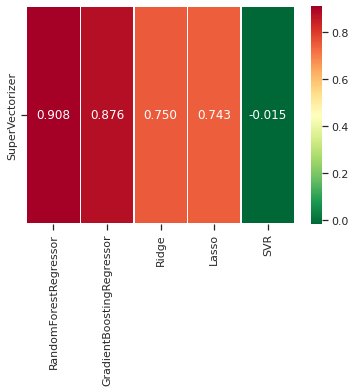

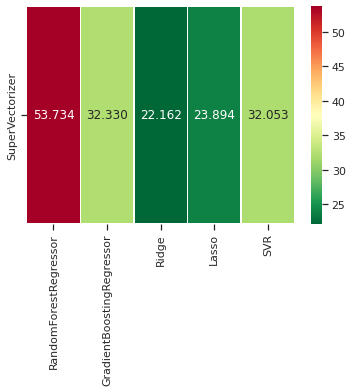

In [ ]:
# MODEL SOLUTION
from dirty_cat import SuperVectorizer

def plot_2_3(X, y):
    models = [RandomForestRegressor(random_state=0),
              GradientBoostingRegressor(random_state=0),
              Ridge(random_state=0),
              Lasso(random_state=0),
              SVR()]
    options = [SuperVectorizer(auto_cast=True)]

    X2 = X.copy()
    X2['gender'] = X2.gender.astype('str')
    X2['department_name'] = X2.department_name.astype('str')
    X2['assignment_category'] = X2.assignment_category.astype('str')
    X2['division'] = X2.division.astype('str')
    X2['employee_position_title'] = X2.employee_position_title.astype('str')
    X2['underfilled_job_title'] = X2.underfilled_job_title.astype('str')

    heatmap_helper(X2, y, models, options, option='encoder')
plot_2_3(X, y)

In [ ]:
#Optional TODO: add some visualization about the learned embedding?

In [ ]:
### MODEL SOLUTION
q_2_3 = """
        We get the best results so far, especially with the random forest (.904 r2 score). 
        Also gradient boosting performs much better now. However, the linear models perform worse.
        The learned embeddings seems useful to capture information about which categories are similar 
        (e.g. which employee positions are similar). This means that we need much fewer features, which
        seems to work well with the tree-based models. The linear models have to work in a much lower-
        dimensional space compared to the one-hot encoder, en hence also work less well.
        """

## Part 3: Feature importance
In this part, we will continue with your `flexible_pipeline`, and we use a random forest to learn which features
are most important to predict the salary of a person. This may reveal how salaries are decided. We will do this with both Random Forest's importance estimates and with permutation importance.

### Question 3.1 (5 points)
Implement a function `plot_3_1` that does the following:  
* Split the data using a standard shuffled train-test split. Use `random_state=0`.
* Combine your `flexible_pipeline`, without feature scaling but with one-hot-encoding, with a RandomForest regressor. Train that pipeline on the training set.
* Remember that the categorical features where encoded. Retrieve their encoded names from the one-hot-encoder (with `get_feature_names`). You can get the encoder from the trained pipeline or ColumnTransformer. Carefully check the documentation.
* Retrieve the feature importances from the trained random forest and match them to the correct names. Depending on how you implemented your `flexible_pipeline` these are likely the first or the last columns in the processed dataset.
* Compute the permutation importances given the random forest pipeline and the test set. Use `random_state=0` and at least 10 iterations.
* Pass the tree-based and permutation importances to the plotting function `compare_importances` below.

In [ ]:
# Plotting function. Do not edit.
def compare_importances(rf_importance, perm_importance, rf_feature_names, feature_names):
    """ Compares the feature importances from random forest to permutation importance
    Keyword arguments:
    rf_importance -- The random forest's feature_importances_
    perm_importance -- The permutation importances as computed by sklearn.inspection.permutation_importance
    rf_feature_names -- The names of the features received by the random forest, in the same order as their importances
    feature_names -- The original features names in their original order
    """
    topk = 30
    # Trees
    sorted_idx = rf_importance.argsort()[-topk:]
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    y_ticks = np.arange(0, topk)
    ax[0].barh(y_ticks, rf_importance[sorted_idx])
    ax[0].set_yticklabels(rf_feature_names[sorted_idx])
    ax[0].set_yticks(y_ticks)
    ax[0].set_title("Random Forest Feature Importances")

    # Permutations
    sorted_idx = perm_importance.importances_mean.argsort()[-topk:]
    ax[1].boxplot(perm_importance.importances[sorted_idx].T, vert=False, labels=feature_names[sorted_idx])
    ax[1].set_title("Permutation Importances (test set)")

    fig.tight_layout()
    plt.show()

In [ ]:
# Implement
def plot_3_1(X, y):
    """ See detailed description above.
    """
    pass

In [ ]:
# MODEL IMPLEMENTATION
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split

# Helper function. Allows to switch encoders.
def compare(X, y, encoder):
    # Train RF
    y=y.astype(int)
    X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, random_state=0)
    rf_pipe = flexible_pipeline(X, RandomForestRegressor(), scaler=None, encoder=encoder)
    rf_pipe.fit(X_train, y_train)

    numerical = X.select_dtypes(exclude=["category","object"]).columns.tolist()
    categorical = X.select_dtypes(include=["category","object"]).columns.tolist()

    # Match feature names
    encoder_name = encoder.__class__.__name__.lower()
    enc = rf_pipe.named_steps['columntransformer'].named_transformers_["remainder"].named_steps[encoder_name]
    feature_names = []
    if encoder_name == 'onehotencoder':
        feature_names = enc.get_feature_names(input_features=categorical)
    elif encoder_name == 'supervectorizer':
        feature_names = enc.get_feature_names()
        print(feature_names)
    else:
        feature_names = [categorical[i] for i in enc.get_feature_names()]
    feature_names = np.r_[numerical,feature_names] #

    # Get importances
    tree_feature_importances = rf_pipe.named_steps['randomforestregressor'].feature_importances_
    permutation_importances = permutation_importance(rf_pipe, X_test, y_test, n_repeats=20,
                                        random_state=0, n_jobs=-1)
    test_feature_names = X_test.columns

    # Plot
    compare_importances(tree_feature_importances, permutation_importances, feature_names, test_feature_names)

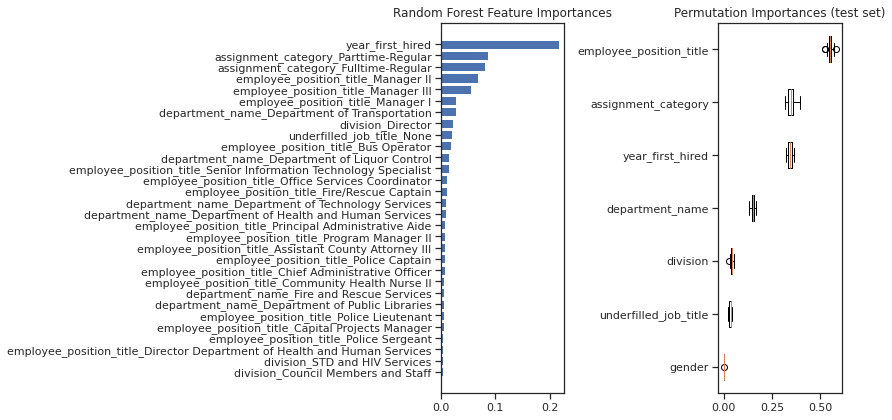

In [ ]:
# MODEL IMPLEMENTATION
def plot_3_1(X,y):
    compare(X,y,OneHotEncoder(sparse=False, handle_unknown='ignore'))
plot_3_1(X,y)   

### Question 3.2 (2 point)
Interpret the results of Question 3.1. What seems to affect salary the most? Do both methods give the same or similar results? If not, what are the differences? Try to explain these differences based on your understanding of how these methods work.

In [ ]:
# Fill in your explanation. Don't change the name of the variable
q_3_2 = """
        Your answer here.
        """

In [ ]:
### MODEL SOLUTION
q_3_2 = """
        Overall, the results are quite similar. The year of first hire, assignment 
        category (fulltime/parttime), and the position title have the most
        influence. The exact ranking differs a bit because with the model-based
        feature importances, we get an importance per category, while permutation
        importance shows the importance of entire features. Especially since
        the position title is split up into hundreds of features, and only some
        categories (positions) affect salary greatly (e.g. manager), they rank a
        little lower in thde model-based estimates, but with more detail. Gender
        only shows up in the permutation importances, but with a very low importance.  
        """

## Part 4: Algoritmic bias
Check whether there is any algorithmic bias in the predictions.

### Question 4.1 Gender bias (3 points)
First, we want to check whether the model gives better predictions for males or for females.

* Use a RandomForest pipeline with 1000 trees and `max_features=0.1`
* Use 3-fold cross validation and return the predictions for every fold
* Separate the test set predictions into different groups depending on the feature 'gender', and report the r2 score for each group.
* Implement a function `plot_4_1` which returns a visualization of these results (e.g. a bar chart)
* Write an interpretation in `q_4_1`

In [ ]:
#Implement
def plot_4_1(X, y):
    """ Returns a bar chart of the AUC measured, grouped by the value for the 'race' feature
    """
    pass

# Fill in your interpretation. Don't change the name of the variable
q_4_1 = """
        Your answer here.
        """

In [ ]:
# MODEL SOLUTION
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_predict
def plot_4_1(X,y,sample_weights=None):
    pipe = flexible_pipeline(X, RandomForestRegressor(n_estimators=1000, max_features=0.1, random_state=1), scaler=None,
                             encoder=OneHotEncoder(handle_unknown='ignore', sparse=False))
    genders = X['gender'].value_counts().index.to_list()
    if sample_weights: # For Q4.2
        predictions = cross_val_predict(pipe, X, y, cv=3, fit_params={"randomforestregressor__sample_weight":sample_weights})
    else:
        predictions = cross_val_predict(pipe, X, y, cv=3)

    labels = []
    scores = []
    for r in genders:
        labels.append(r)
        scores.append(r2_score(y[X.gender == r], predictions[X.gender == r]))
    fig, ax = plt.subplots(figsize=(6, 3))
    ax.barh(labels, scores)
    ax.set_yticklabels(labels)
    fig.tight_layout()
    plt.show()
    
    return scores

In [ ]:
rscores = plot_4_1(X,y)

In [ ]:
### MODEL SOLUTION
q_4_1 = """
        The model is equally accurate for both males and females. It doesn't seem to be biased.
        This doesn't mean that the salaries are equal for both genders, only that the model
        can predict both equally accurately.
        """

### Question 4.2 (3 points)
Second, since the data contains more males than females, we want to check whether we can get a better model if we balance the data by giving more
weight to the examples about female employees.

* Implement a function `plot_4_2` where you weight the samples (instances) with a weight inversely proportional to their frequency and then visualise the results in the same way as in question 4.1 (as a bar chart).
* Interpret the results and explain them in `answer_q_4_2`.

In [ ]:
#Implement
def plot_4_2(X, y):
    """ Returns a bar chart of the score measured, grouped by the value for the 'gender' feature
    """
    pass

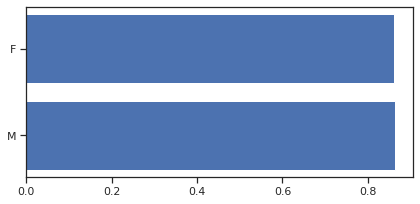

M -0.0001817909183263744
F 0.0018450985948743615


In [ ]:
# MODEL SOLUTION
def plot_4_2(X,y):
    # Get weights per sample. We need to impute some nans (replace by majority class)
    gender_weights = 100/X['gender'].value_counts()
    sample_weights = [gender_weights[r if r is not np.nan else 'M'] for r in X['gender']]
    rscores2 = plot_4_1(X,y,sample_weights=sample_weights)
    
    #print differences
    for i, r in enumerate(gender_weights.index.values):
        print(r, rscores2[i] - rscores[i])
        
plot_4_2(X,y)

In [ ]:
answer_q_4_2 = """
               The model for females is only 0.0018 better, probably less than the
               estimation uncertainty of the cross-validation. Hence, the reweighting
               did not have a large effect. The unbalance between males and females
               in the data is not so large, and the model was already able to make
               good predictions before.
               """

In [ ]:
print(time.time()-start_time)